Generate phoenix models for all teff/logg combinations and compare with Gonzales+19 spectra and G430l

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
import prepare_phoenix as pp


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
teffs = np.array([2650, 2559, 2658, 2610])*u.K
distances = np.array([12.49, 12.1, 12.43,12.11])*u.pc
masses = np.array([0.08, 0.08, 0.086,0.0898])*u.M_sun
radii = np.array([0.121, 0.117, 0.119,0.112])*u.R_sun
sources = ['b+m17', 'g+17', 'g+19', 'MM']

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
loggs = []
for m, r, t in zip(masses, radii, teffs):
    g = G*(m)/(r)**2
    g =  g.to(u.cm/u.s**2)
    loggs.append(np.log10(g.value))
    #print(t,np.log10(g.value))
loggs = np.array(loggs)
loggs[2] = 5.21
#print(loggs)

params = dict(Sources=sources, Teff = teffs, Distance=distances, Mass=masses, Radius=radii, Logg=loggs)
params = Table(params)
print(params)    


#b+m17
#teff = 2650*u.K
#distance = 12.49*u.pc #~consistant with gaia
#mass = 0.080*u.M_sun
#radius = 0.121*u.R_sun

#g+17
#teff = 2559*u.K
#distance = 12.1*u.pc
#mass = 0.080*u.M_sun
#radius = 0.117*u.R_sun

#gonzales+19 w. gaia! https://arxiv.org/pdf/1909.13859.pdf
#teff = 2628*u.K
#distance = 12.43*u.pc
#mass = 90*u.M_jup
#radius = 1.16*u.R_jup
#logg = 5.21
#FeH = 0.04


#g = ((const.G.to(u.cm**3/(u.g*u.s**2))*mass.to(u.g))/(radius.to(u.cm)**2))
#print(g)
#logg = np.log10(g.value)

Sources  Teff  Distance   Mass  Radius        Logg      
          K       pc    solMass solRad                  
------- ------ -------- ------- ------ -----------------
  b+m17 2650.0    12.49    0.08  0.121 5.175586873662176
   g+17 2559.0     12.1    0.08  0.117 5.204785890802754
   g+19 2658.0    12.43   0.086  0.119              5.21
     MM 2610.0    12.11  0.0898  0.112 5.292907918630075


In [3]:
save_path = 'interpolated_models/'
repo = '/media/david/5tb_storage1/muscles/btsettl_models/'
for row in params:
    star = 'Trappist-1_{}'.format(row['Sources'])
    star_params = {'Teff': row['Teff'], 'logg': row['Logg'], 'FeH': 0.00, 'aM': 0, 'Radius':row['Radius']*u.R_sun, 'Distance':row['Distance']*u.pc}
    #print(star_params['Distance'])
#    pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True)

In [4]:
specs = glob.glob('interpolated_models/*ecsv')
"""for sp in specs:
    data = Table.read(sp)
    print (data.meta)
    plt.plot(data['WAVELENGTH'], data['FLUX']*data.meta['NORMFAC'])
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-18)
    plt.xlim(3000, 10000)"""
   # plt.show()

"for sp in specs:\n    data = Table.read(sp)\n    print (data.meta)\n    plt.plot(data['WAVELENGTH'], data['FLUX']*data.meta['NORMFAC'])\n    plt.xscale('log')\n    plt.yscale('log')\n    plt.ylim(1e-18)\n    plt.xlim(3000, 10000)"

In [5]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=2):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

In [6]:
specs = glob.glob('interpolated_models/*ecsv')
"""for sp in specs:
    data = Table.read(sp)
    print (data.meta)
    w, f = data['WAVELENGTH'], data['FLUX']*data.meta['NORMFAC']
    w, f = smear(w, f, 1000) 
    plt.plot(w, f)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-18)
    plt.xlim(3000, 10000)"""

"for sp in specs:\n    data = Table.read(sp)\n    print (data.meta)\n    w, f = data['WAVELENGTH'], data['FLUX']*data.meta['NORMFAC']\n    w, f = smear(w, f, 1000) \n    plt.plot(w, f)\n    plt.xscale('log')\n    plt.yscale('log')\n    plt.ylim(1e-18)\n    plt.xlim(3000, 10000)"

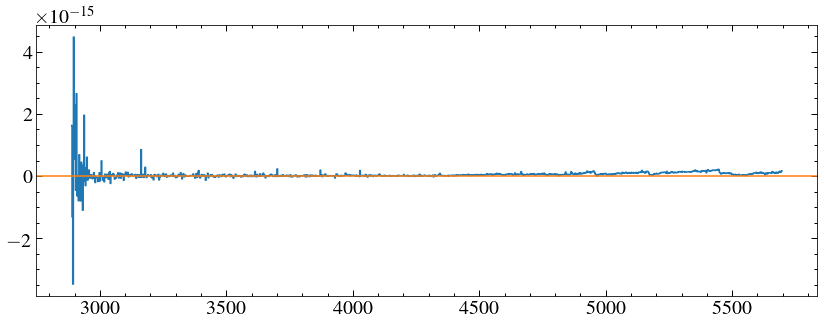

In [7]:

sdata = fits.getdata('../combined/odlm41010_sx1.fits',1)[0]
wo, fo, eo = sdata['WAVELENGTH'], sdata['FLUX'], sdata['ERROR']
#plt.step(wo, fo, where='mid')

mask = (wo <3345) | (wo > 3365) & (wo < 5321) | (wo > 5325) & (wo < 5476.5) | (wo > 5480.5) #cutting out overlap and cosmics
wo, fo, eo = wo[mask], fo[mask], eo[mask]
plt.step(wo, fo, where='mid')
plt.axhline(0, c='C1')
#plt.ylim(0, 0.2e-14)
#plt.xlim(3340, 3370)


Clean up optical data using same tecnique as before, have to be careful to avoid Ca ii lines- no problem

In [8]:
def error_cut(w, f, e, bin_width = 30): #cut region before a rolling 30pt mean SN > 1
    sn = np.array([np.mean(f[i:i+bin_width]/e[i:i+bin_width]) for i in range(len(w[:-bin_width]))])
    start = w[:-bin_width][np.where(sn > 1)[0][0]]
    mask = (w > start) & (f > 0)
    return w[mask], f[mask], e[mask]


2888.3135622411687 5696.381658058151
3871.815639156187
147 204


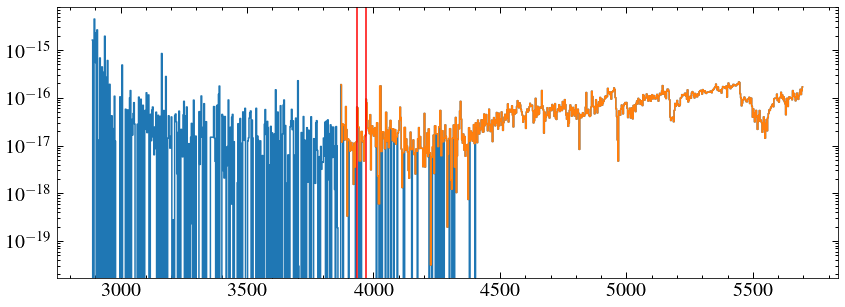

In [9]:
plt.step(wo, fo, where='mid')
print(wo[0], wo[-1])
wo2, fo2, eo2 = error_cut(wo, fo, eo)
plt.step(wo2, fo2, where='mid')
plt.yscale('log')
ca =[ 3933.6614, 3968.4673]
[plt.axvline(line, c='r') for line in ca]
print(wo2[0])

fc = fo[wo< wo2[0]]
print(len(fc[fc < 0]), len(fc[fc > 0] ))

In [10]:
"""for sp in specs:
    data = Table.read(sp)
    print (data.meta)
    w, f = data['WAVELENGTH'], data['FLUX']*data.meta['NORMFAC']
    w, f = smear(w, f, 1000) 
    plt.plot(w, f, label='{}'.format(data.meta['TEFF']))
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-18, 1e-15)
    plt.xlim(3800, 6000)
plt.step(wo2, fo2, where='mid')
plt.legend(loc=4)"""

"for sp in specs:\n    data = Table.read(sp)\n    print (data.meta)\n    w, f = data['WAVELENGTH'], data['FLUX']*data.meta['NORMFAC']\n    w, f = smear(w, f, 1000) \n    plt.plot(w, f, label='{}'.format(data.meta['TEFF']))\n    plt.xscale('log')\n    plt.yscale('log')\n    plt.ylim(1e-18, 1e-15)\n    plt.xlim(3800, 6000)\nplt.step(wo2, fo2, where='mid')\nplt.legend(loc=4)"

Let's compare at the OIR...

6333.500146865845


"for sp in specs:\n    data = Table.read(sp)\n    print (data.meta)\n    w, f = data['WAVELENGTH'], data['FLUX']*data.meta['NORMFAC']\n    w, f = smear(w, f, 1000) \n    plt.plot(w, f, label='{}'.format(data.meta['TEFF']))\nplt.xscale('log')\nplt.yscale('log')\nplt.xlim(gw[0], gw[-1])\nplt.ylim(1e-16, 2.5e-14)"

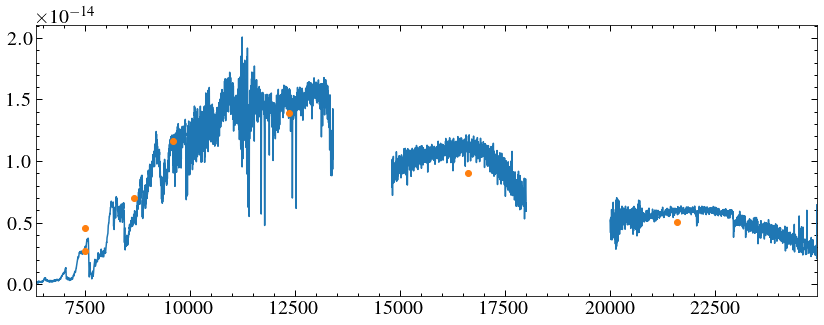

In [11]:
irpath = '/home/david/work/muscles/SEDs/trappist-1/ir_data/'

g19data = glob.glob(irpath+'PS_Gaia*')
g19data

gw, gf, ge = np.loadtxt(g19data[0], unpack=True)
gw *=10000
gphot = np.genfromtxt(g19data[1], dtype=None, delimiter=',', names=True, encoding=None)
gpn, gpw, gpf, gpe = gphot['Band'], gphot['Wavelength'], gphot['Flux'], gphot['Error'] 
gpw*=10000
plt.plot(gw, gf)
plt.errorbar(gpw, gpf, yerr=gpe, marker='o', ls='none')

plt.xlim(gw[0], gw[-1])
print(gw[0])

"""for sp in specs:
    data = Table.read(sp)
    print (data.meta)
    w, f = data['WAVELENGTH'], data['FLUX']*data.meta['NORMFAC']
    w, f = smear(w, f, 1000) 
    plt.plot(w, f, label='{}'.format(data.meta['TEFF']))
plt.xscale('log')
plt.yscale('log')
plt.xlim(gw[0], gw[-1])
plt.ylim(1e-16, 2.5e-14)"""

In [12]:
print(distances)
print(teffs)


[12.49 12.1  12.43 12.11] pc
[2650. 2559. 2658. 2610.] K


In [13]:
"""dratio = 12.45/12.1 

#OrderedDict([('LOGG', 5.21), ('NORMFAC', <Quantity 4.65902008e-20>), ('TEFF', 2658.0)])
#OrderedDict([('LOGG', 5.175586873662176), ('NORMFAC', <Quantity 4.7707733e-20>), ('TEFF', 2650.0)])
#OrderedDict([('LOGG', 5.204785890802754), ('NORMFAC', <Quantity 4.75273828e-20>), ('TEFF', 2559.0)])
#OrderedDict([('LOGG', 5.292907918630075), ('NORMFAC', <Quantity 4.34801141e-20>), ('TEFF', 2610.0)])


r = [1, 1, dratio, dratio]
for i, sp in enumerate(specs):
    data = Table.read(sp)
    print (data.meta)
    w, f = data['WAVELENGTH'], data['FLUX']*data.meta['NORMFAC']
    w, f = smear(w, f, 1000)
    plt.plot(w, f, label='{}'.format(data.meta['TEFF']))
    plt.plot(w, f/r[i], label='{}'.format(data.meta['TEFF']))
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-18, 1e-15)
plt.xlim(3800, 6000)"""

"dratio = 12.45/12.1 \n\n#OrderedDict([('LOGG', 5.21), ('NORMFAC', <Quantity 4.65902008e-20>), ('TEFF', 2658.0)])\n#OrderedDict([('LOGG', 5.175586873662176), ('NORMFAC', <Quantity 4.7707733e-20>), ('TEFF', 2650.0)])\n#OrderedDict([('LOGG', 5.204785890802754), ('NORMFAC', <Quantity 4.75273828e-20>), ('TEFF', 2559.0)])\n#OrderedDict([('LOGG', 5.292907918630075), ('NORMFAC', <Quantity 4.34801141e-20>), ('TEFF', 2610.0)])\n\n\nr = [1, 1, dratio, dratio]\nfor i, sp in enumerate(specs):\n    data = Table.read(sp)\n    print (data.meta)\n    w, f = data['WAVELENGTH'], data['FLUX']*data.meta['NORMFAC']\n    w, f = smear(w, f, 1000)\n    plt.plot(w, f, label='{}'.format(data.meta['TEFF']))\n    plt.plot(w, f/r[i], label='{}'.format(data.meta['TEFF']))\nplt.xscale('log')\nplt.yscale('log')\nplt.ylim(1e-18, 1e-15)\nplt.xlim(3800, 6000)"

Differences are small in comparison with their divergence from the G+ spectra

In [14]:
spec = specs[0]
data = Table.read(spec)
print (data.meta)
pw, pf = data['WAVELENGTH'], data['FLUX']*data.meta['NORMFAC']
pws, pfs = smear(pw, pf, 1200)

OrderedDict([('LOGG', 5.21), ('NORMFAC', <Quantity 4.65902008e-20>), ('TEFF', 2658.0)])


In [15]:
gphot

array([('2MASS_H',  16620.  , 9.03295631e-15, 1.74712865e-16),
       ('2MASS_J',  12350.  , 1.38869082e-14, 2.81386932e-16),
       ('2MASS_Ks',  21590.  , 5.03672309e-15, 1.06696848e-16),
       ('Gaia_BP',   5500.  , 1.67060077e-16, 7.38566480e-18),
       ('Gaia_RP',   7500.  , 4.58154633e-15, 4.64173612e-17),
       ('PS_g',   4775.62, 1.36671707e-16, 2.51758588e-18),
       ('PS_i',   7484.6 , 2.71157849e-15, 2.74720169e-17),
       ('PS_r',   6219.5 , 3.15455417e-16, 3.19599694e-18),
       ('PS_y',   9603.1 , 1.16085967e-14, 1.17611039e-16),
       ('PS_z',   8657.8 , 6.96645214e-15, 7.05797349e-17),
       ('WISE_W1',  33526.  , 1.21530218e-15, 2.57446976e-17),
       ('WISE_W2',  46028.  , 4.48866439e-16, 8.26842537e-18),
       ('WISE_W3', 115608.  , 1.55425075e-17, 5.86922316e-19)],
      dtype=[('Band', '<U8'), ('Wavelength', '<f8'), ('Flux', '<f8'), ('Error', '<f8')])

In [16]:
def make_phot(bp_w, bp_cc, w, f):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    return np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)

fake_phot = []
filter_path = '/home/david/work/filters/'
for band in gpn:
    index = band.find('_')
    inst = band[:index].lower()
    flt = band[index+1:]
    if inst == 'ps':
        inst = 'panstarrs'
        flt = 'PS1.{}'.format(flt)
    if inst == 'gaia':
        flt = flt[0]+flt[1:].lower()
    bpath = '{}{}/{}.dat'.format(filter_path, inst, flt)
    bw, bc = np.loadtxt(bpath, unpack=True)
    phot = make_phot(bw, bc, np.array(pw), pf)
    fake_phot.append(phot)
    #print(bpath)
    #if os.path.exists(bpath):
    #    print('yes')
    #else:
     #   print('no')

print(fake_phot)

[<Quantity 7.18777275e-15>, <Quantity 1.14674306e-14>, <Quantity 3.42275388e-15>, <Quantity 1.71339464e-16>, <Quantity 4.36688267e-15>, <Quantity 1.54174931e-16>, <Quantity 2.97590249e-15>, <Quantity 2.8993366e-16>, <Quantity 1.05976151e-14>, <Quantity 7.33684261e-15>, <Quantity 8.02098302e-16>, <Quantity 2.79332177e-16>, <Quantity 1.000966e-17>]


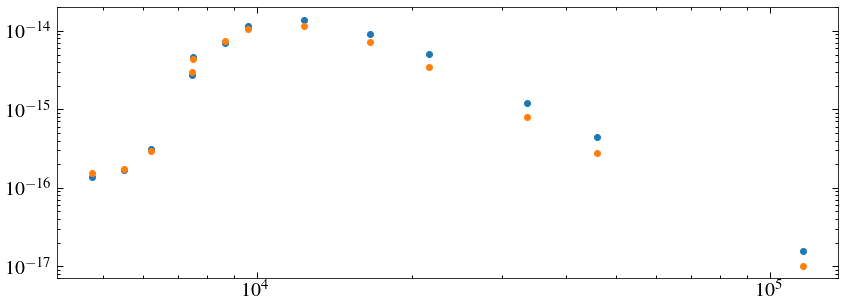

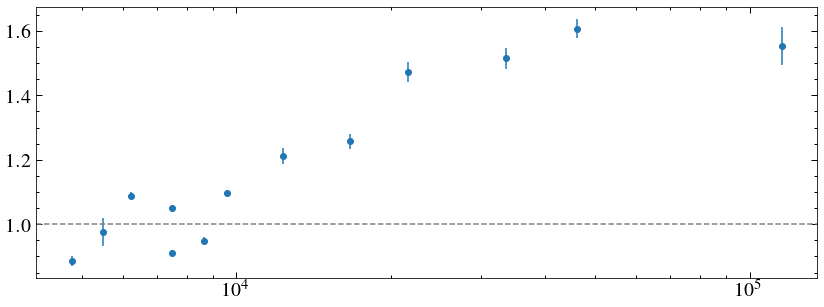

In [17]:
plt.errorbar(gpw, gpf, yerr=gpe, marker='o', ls='none')
plt.errorbar(gpw, fake_phot, marker='o', ls='none')
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.errorbar(gpw, gpf/fake_phot, yerr=gpe/fake_phot, marker='o', ls='none')
plt.xscale('log')
plt.axhline(1, ls='--', c='0.5')



Can a flare make a difference? Add a 10000K bb?

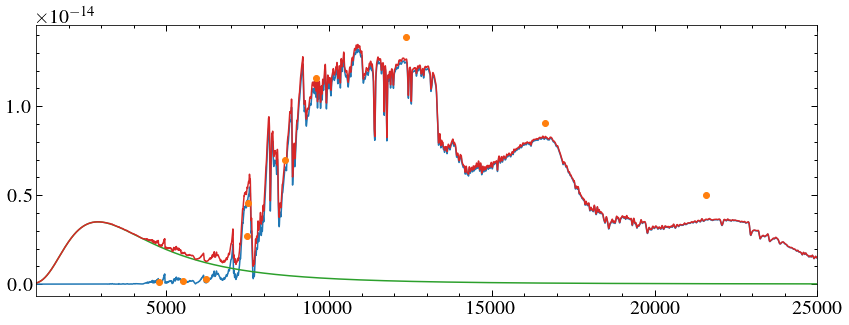

In [18]:
from astropy.modeling.models import BlackBody
from astropy.modeling import models
from astropy.visualization import quantity_support

#bb1 = models.BlackBody(temperature=10000*u.K)
#print(bb1.bolometric_flux)
#tflux = 2.8e29

bb = BlackBody(temperature=10000*u.K)
wav = np.array(pw)*u.AA 
flux = bb(wav)
flux = flux.to(u.erg/u.cm**2/u.s/u.AA/u.sr, equivalencies = u.spectral_density(wav))
scale = np.max(flux)/3.5e-15
flux /= scale

plt.figure()

plt.plot(pws, pfs)
plt.errorbar(gpw, gpf, marker='o', ls='none')
plt.plot(wav, flux)

f_flare = pfs+flux
plt.plot(pws, f_flare)

#plt.ylim(1e-17)
plt.xlim(1000, 25000)
#plt.yscale('log')
plt.show()



So it's not a flare.

[5.969350653453509e-15, 8.865380944944671e-15, 3.2857336671444604e-15, 1.1053840677893503e-15, 6.057482615942266e-15, 8.872998717536036e-15, 3.0680171488075084e-15, 5.534525105618379e-16, 6.619870804942781e-17, 1.7177465912415414e-15, 1.7668864596784e-16, 4.188157740039264e-18, 5.677100243188231e-15, 8.090234025377793e-16]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


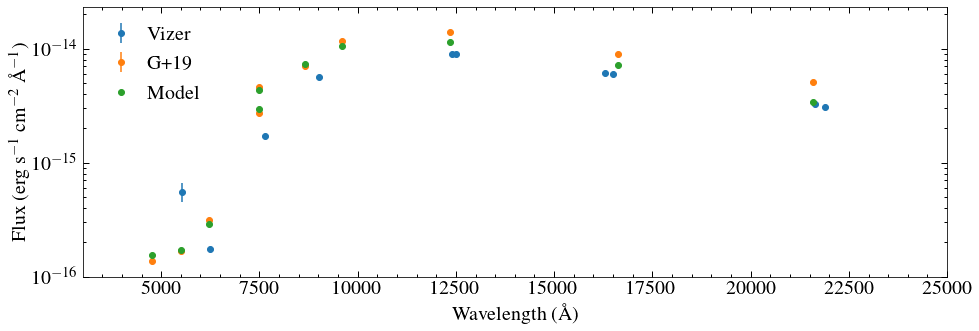

In [19]:
from astropy.io.votable import parse
tphot = '../../photometry/vizer_tables/Trappist-1.vot'
c = 2.998e8*u.m/u.s

votable = parse(tphot)
table = votable.get_first_table()
data = table.array
mask = ~data['sed_eflux'].mask
masked_data = data[mask].data
filters = np.unique(masked_data['sed_filter'].data)
w = []
f = []
e = []
for filter in filters:
    w1 = (np.mean(masked_data['sed_freq'][masked_data['sed_filter']==filter])*u.GHz).to(u.AA, equivalencies=u.spectral())
    fj1 = masked_data['sed_flux'][masked_data['sed_filter']==filter]
    e1 = masked_data['sed_eflux'][masked_data['sed_filter']==filter]
    if len(fj1) >1:
        fj_av = np.average(fj1, weights = (1/(e1**2)))
        e1_av = abs(np.average((fj1-fj_av), weights = (1/(e1**2))))**0.5
    else:
        fj_av, e1_av = fj1[0], e1[0]
    f1 = (fj_av*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(w1)) 
    w.append(w1.value)
    f.append(f1.value)
    e.append(((e1_av*f1)/fj_av).value)
# plt.figure('sed', figsize=(5,5))
print(f)
w, f, e = np.array(w), np.array(f), np.array(e)
plt.errorbar(w[e>0], f[e>0], yerr=e[e>0], marker='o', ls='none', c='C0', label='Vizer')

#for i in range(len(w)):
 #   if e[i] !=0.0:
        #plt.errorbar(w[i].value, f[i].value, yerr=e[i].value, marker='o', ls='none', label = filters[i], c='C0', label='Vizer')
  #      
   # else:
    #    plt.errorbar(w[i].value, f[i].value, yerr=f[i].value*0.1, marker='o', ls='none', uplims=True,label = filters[i])
plt.yscale('log')
#plt.xscale('log')

plt.errorbar(gpw, gpf, yerr=gpe, marker='o', ls='none', c='C1', label=r'G+19')
plt.errorbar(gpw, fake_phot, marker='o', ls='none', c='C2', label='Model')
plt.ylim(1e-16)
plt.xlim(3000, 25000)
plt.legend()
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.xlabel('Wavelength (\AA)')
plt.tight_layout()        

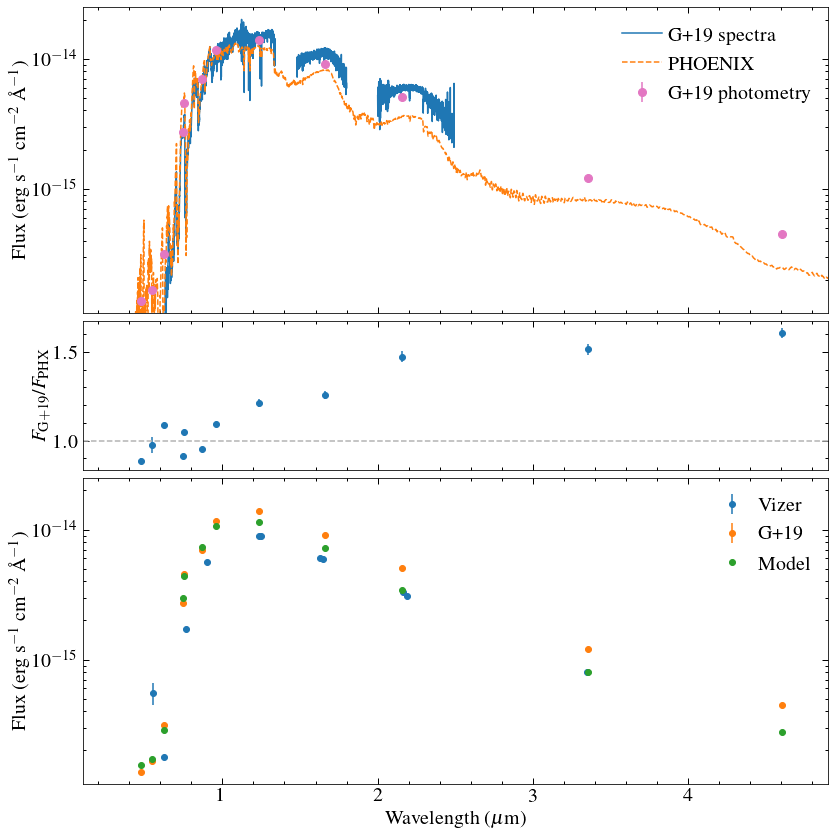

In [20]:

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(5, 1, figure=fig)

plt.subplot(gs[:2, :])
plt.plot(gw/10000, gf, label = 'G+19 spectra')
plt.errorbar(gpw/10000, gpf, yerr=gpe, marker='o', ls='none', label = 'G+19 photometry', zorder=10, markersize=8, c='C6')


plt.plot(pws/10000, pfs, label='PHOENIX', c='C1', ls='--')

plt.xlim(gw[0]/10000, gw[-1]/10000)
plt.xlim(0.3, 2.5)
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)
#plt.xscale('log')
plt.yscale('log')
#plt.xticks((0.7, 1, 1.5, 2), ('0.7', '1', '1.5', '2'))
plt.legend(loc=1)
plt.ylim(1.1e-16, 2.5e-14)
plt.xlim(0.1,4.9)
plt.xticks(visible=False)


plt.subplot(gs[2:3, :])
plt.errorbar(gpw/10000, gpf/fake_phot, yerr=gpe/fake_phot, marker='o', ls='none')
plt.axhline(1.0, ls='--', c='0.7')
#plt.xlim(gw[0]/10000, gw[-1]/10000)
plt.ylabel('$F_{\mathrm{G+19}}$/$F_{\mathrm{PHX}}$', size=20)

#plt.xscale('log')
#plt.xticks((0.7, 1, 1.5, 2), ('0.7', '1', '1.5', '2'))
plt.xlim(0.1,4.9)
plt.xticks(visible=False)

plt.subplot(gs[3:, :])
plt.errorbar(w[e>0]/10000, f[e>0], yerr=e[e>0], marker='o', ls='none', c='C0', label='Vizer')
plt.errorbar(gpw/10000, gpf, yerr=gpe, marker='o', ls='none', c='C1', label=r'G+19')
plt.errorbar(gpw/10000, fake_phot, marker='o', ls='none', c='C2', label='Model')
plt.yscale('log')
#plt.xticks((0.7, 1, 1.5, 2), ('0.7', '1', '1.5', '2'))
plt.legend(loc=1)
plt.ylim(1.1e-16, 2.5e-14)
plt.xlim(0.1,4.9)
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.xlabel('Wavelength ($\mu$m)', size=20)
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
#plt.ylim(0.1, 2.9)
#plt.savefig('../plots/t1_phoenix_exoupdate.png')


In [21]:
#check conversion of mag to flux
mband = ['J', 'H', 'Ks']
wband = [1.235, 1.662, 2.159]
mags  = [11.354, 10.718,10.296]
zp = [1594, 1024,666.7] #jy
#vega conversions from http://www.astronomy.ohio-state.edu/~martini/usefuldata.html
vcon = [0.91, 1.39, 1.85]
vzp = [1589, 1021, 640]
f2m = []
for i, m in enumerate(mags):
    print(mband[i])
    m -= vcon[i]
    mj = vzp[i]*10**(m/-2.5)
    print(mj)
    f1 = (mj*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(wband[i]*u.um)) 
    print(f1)
    f2m.append(f1.value)
f2m = np.array(f2m)    

ps_band = ['g', 'r', 'i', 'z', 'y']
ps_mags = [19.35, 17.8, 15.13,13.73,12.97]
ps_w = [0.4810, 0.6170, 0.7520,0.8660, 0.9620]
zpps = 3631

f2p = []
for i, m in enumerate(ps_mags):
 #   print(ps_band[i])
    mj = zpps*10**(m/-2.5)
  #  print(mj)
    f1 = (mj*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(ps_w[i]*u.um)) 
   # print(f1)
    f2p.append(f1.value)
f2p = np.array(f2p) 

J
0.1055659589659873
2.0749645671648763e-14 erg / (Angstrom cm2 s)
H
0.18959450326217622
2.057711127483917e-14 erg / (Angstrom cm2 s)
Ks
0.2677811325231538
1.7222468228184497e-14 erg / (Angstrom cm2 s)


In [22]:
gphot

array([('2MASS_H',  16620.  , 9.03295631e-15, 1.74712865e-16),
       ('2MASS_J',  12350.  , 1.38869082e-14, 2.81386932e-16),
       ('2MASS_Ks',  21590.  , 5.03672309e-15, 1.06696848e-16),
       ('Gaia_BP',   5500.  , 1.67060077e-16, 7.38566480e-18),
       ('Gaia_RP',   7500.  , 4.58154633e-15, 4.64173612e-17),
       ('PS_g',   4775.62, 1.36671707e-16, 2.51758588e-18),
       ('PS_i',   7484.6 , 2.71157849e-15, 2.74720169e-17),
       ('PS_r',   6219.5 , 3.15455417e-16, 3.19599694e-18),
       ('PS_y',   9603.1 , 1.16085967e-14, 1.17611039e-16),
       ('PS_z',   8657.8 , 6.96645214e-15, 7.05797349e-17),
       ('WISE_W1',  33526.  , 1.21530218e-15, 2.57446976e-17),
       ('WISE_W2',  46028.  , 4.48866439e-16, 8.26842537e-18),
       ('WISE_W3', 115608.  , 1.55425075e-17, 5.86922316e-19)],
      dtype=[('Band', '<U8'), ('Wavelength', '<f8'), ('Flux', '<f8'), ('Error', '<f8')])

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


(7e-17, 3.03976669864074e-14)

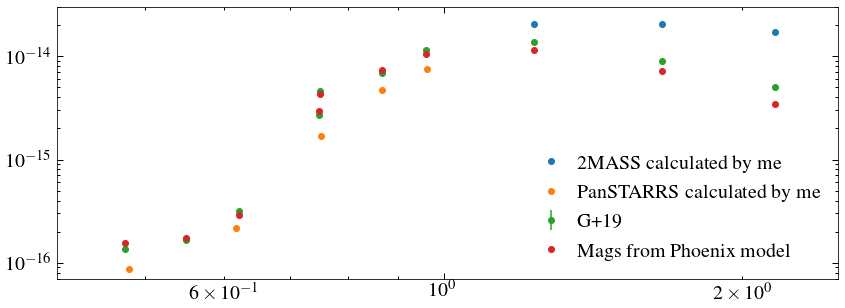

In [23]:
plt.errorbar(np.array(wband), f2m, ls='none', marker='o', c='C0', label= '2MASS calculated by me')
plt.errorbar(np.array(ps_w), f2p, ls='none', marker='o', c='C1' ,label= 'PanSTARRS calculated by me')
plt.errorbar(gpw/10000, gpf, yerr=gpe, marker='o', ls='none', label=r'G+19', c='C2')
plt.errorbar(gpw/10000, fake_phot, marker='o', ls='none', label='Mags from Phoenix model', c='C3')
#plt.plot(pws, pfs)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(0,2.5)
plt.ylim(7e-17)

Need to make a new full photometry array

In [24]:
gphot['Band']

array(['2MASS_H', '2MASS_J', '2MASS_Ks', 'Gaia_BP', 'Gaia_RP', 'PS_g',
       'PS_i', 'PS_r', 'PS_y', 'PS_z', 'WISE_W1', 'WISE_W2', 'WISE_W3'],
      dtype='<U8')

In [25]:
allmags = [10.718, 11.354, 10.296, 18.998, 14.1,19.35,15.13, 17.8, 12.97, 13.73,10.042,9.80,9.528]
magerr = [0.021, 0.022,0.023, 0.048, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.023, 0.02, 0.041]
zpoints = [1024, 1594, 666.7, 3393.3, 2485.1, 3631,3631,3631,3631,3631,309.54,171.79, 31.676]

f2m = []
e2m = []
for i, m in enumerate(allmags):
    #print(mband[i])
    mj = zpoints[i]*10**(m/-2.5)
   # print(mj)
    f1 = (mj*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(gphot['Wavelength'][i]*u.AA))
    e1 = f1 * magerr[i] * np.log(10) / 2.5
    #print(f1)
    f2m.append(f1.value)
    e2m.append(e1.value)
f2m = np.array(f2m)
e2m = np.array(e2m)
print(f2m)
print(e2m)

[5.73665352e-15 9.00274823e-15 3.26471950e-15 8.46286827e-17
 3.03418492e-15 8.68535206e-17 1.72389084e-15 2.13469586e-16
 7.65639003e-15 4.67769449e-15 7.94280682e-16 2.92263361e-16
 1.09742604e-17]
[1.10956716e-16 1.82420426e-16 6.91591090e-17 3.74140307e-18
 2.79458759e-17 1.59990097e-18 1.58776214e-17 1.96612754e-18
 7.05179582e-17 4.30831584e-17 1.68258695e-17 5.38369006e-18
 4.14414362e-19]


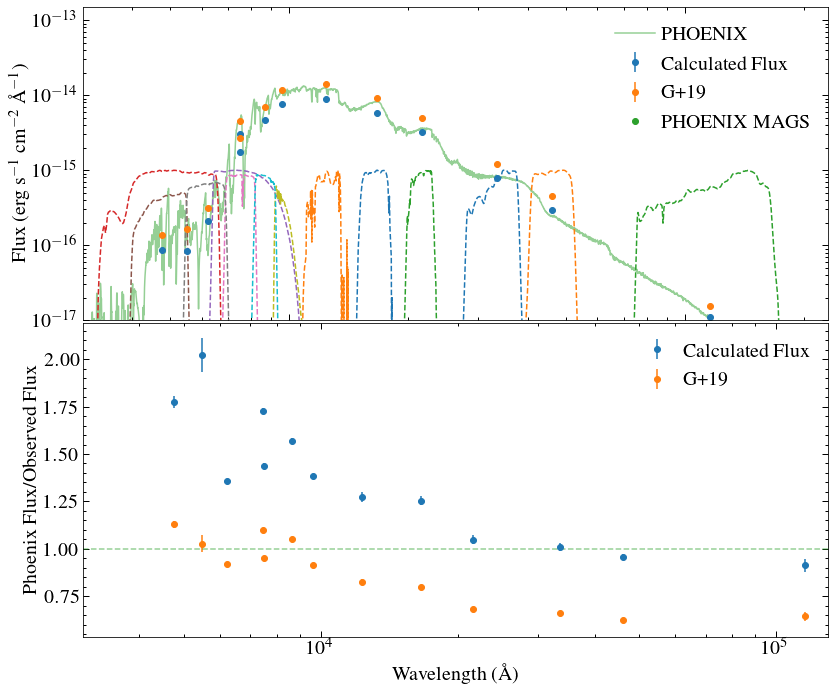

In [26]:
plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.errorbar(gpw, f2m, yerr=e2m, ls='none', marker='o', label='Calculated Flux', c='C0')
plt.errorbar(gpw, gpf, yerr=gpe, marker='o', ls='none', label=r'G+19', c='C1')
plt.plot(pws, pfs, alpha=0.5, zorder=-10, c='C2', label = 'PHOENIX')
plt.errorbar(gpw/10000, fake_phot, marker='o', ls='none', c='C2', label='PHOENIX MAGS')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.xlim(3001, 229999)
plt.ylim(1e-17)
plt.legend()
plt.xticks(visible=False)

for band in gphot['Band']:
    index = band.find('_')
    inst = band[:index].lower()
    flt = band[index+1:]
    if inst == 'ps':
        inst = 'panstarrs'
        flt = 'PS1.{}'.format(flt)
    if inst == 'gaia':
        flt = flt[0]+flt[1:].lower()
    bpath = '{}{}/{}.dat'.format(filter_path, inst, flt)
    bw, bc = np.loadtxt(bpath, unpack=True)
    plt.plot(bw, bc*1e-15, ls='--')


plt.subplot(212)
#ratio = gpf/f2m
#eratio = ratio * ((e2m/f2m)**2 + (gpe/gpf)**2)**0.5

ratio = fake_phot/gpf
eratio = ratio * (gpe/gpf)


pratio = fake_phot/f2m
peratio = pratio * (e2m/f2m)

plt.errorbar(gpw, pratio, yerr=peratio, ls='none', marker='o', label ='Calculated Flux')
plt.errorbar(gpw, ratio, yerr=eratio, ls='none', marker='o', label = 'G+19') 

plt.xscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Phoenix Flux/Observed Flux')
plt.xlim(3001, 129999)
plt.legend()
plt.axhline(1, c='C2', alpha=0.5, ls='--')
plt.tight_layout()
plt.subplots_adjust(hspace=0.01)
#plt.savefig('../plots/trappist1_photometry.pdf')
#[plt.annotate(r'{}'.format(b.replace('_', ' ')), (xi, 2.0), rotation =90) for b, xi in zip(gphot['Band'], gpw)]

In [27]:
(0.532 * u.photon/u.s/u.cm**2/u.Hz).to(u.Jy, equivalencies=u.spectral_density(5500 * u.AA))

<Quantity 1.9214349e+11 Jy>

Looking at the G140M data again, need to redo the photometry and make sure that the bandpasses are covered by the spectrum. 

In [28]:
optphot = np.array([gphot[3], gphot[5]])
optphot

array([('Gaia_BP', 5500.  , 1.67060077e-16, 7.38566480e-18),
       ('PS_g', 4775.62, 1.36671707e-16, 2.51758588e-18)],
      dtype=[('Band', '<U8'), ('Wavelength', '<f8'), ('Flux', '<f8'), ('Error', '<f8')])

In [48]:
def make_phot(bp_w, bp_cc, w, f):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    return np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)

opt_fake_phot = []
filter_path = '/home/david/work/filters/'
for band in optphot['Band']:
    index = band.find('_')
    inst = band[:index].lower()
    flt = band[index+1:]
    if inst == 'ps':
        inst = 'panstarrs'
        flt = 'PS1.{}'.format(flt)
    if inst == 'gaia':
        flt = flt[0]+flt[1:].lower()
    bpath = '{}{}/{}.dat'.format(filter_path, inst, flt)
    bw, bc = np.loadtxt(bpath, unpack=True)
    phot = make_phot(bw, bc, wo2, fo2)
    opt_fake_phot.append(phot)
    
#adding sdss g'
sdssg_w = 4820
sdssg_mag = 19.168 
sdssg_e = 0.012
sdssg_zp = 3631
bpath = '{}{}/{}.dat'.format(filter_path, 'sdss', 'g')
bw, bc = np.loadtxt(bpath, unpack=True, usecols=(0,1))
specg = make_phot(bw, bc, wo2, fo2)  
mj = sdssg_zp*10**(sdssg_mag/-2.5)
sdssg_f  = (mj*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(sdssg_w*u.AA))
sdssg_fe = f1 * sdssg_e * np.log(10) / 2.5
print(sdssg_f, sdssg_fe)
print(specg)
print(sdssg_f.value/specg)
print(f2m[5])
print(opt_fake_phot[1])


#B mag
B_w = 4400
B_mag = 19.8 
B_e = B_mag*0.1
B_zp =  4000.87
bpath = '{}{}/{}.dat'.format(filter_path, 'johnson', 'johnson_B')
bw, bc = np.loadtxt(bpath, unpack=True, usecols=(0,1))
specb = make_phot(bw, bc, wo2, fo2)  
mj = B_zp*10**(B_mag/-2.5)
B_f  = (mj*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(B_w*u.AA))
B_fe = f1 * B_e * np.log(10) / 2.5
print(B_f, B_fe)
print(specb)
print(B_f.value/specb)
#print(f2m[5])
#print(opt_fake_phot[1])


1.0082143520126394e-16 erg / (Angstrom cm2 s) 1.2129200837639079e-19 erg / (Angstrom cm2 s)
6.081981462317853e-17
1.6577070454082037
8.685352059107001e-17
7.424687420088843e-17
7.448516601314335e-17 erg / (Angstrom cm2 s) 2.0013181382104485e-17 erg / (Angstrom cm2 s)
3.9260949087462016e-17
1.897182002585113


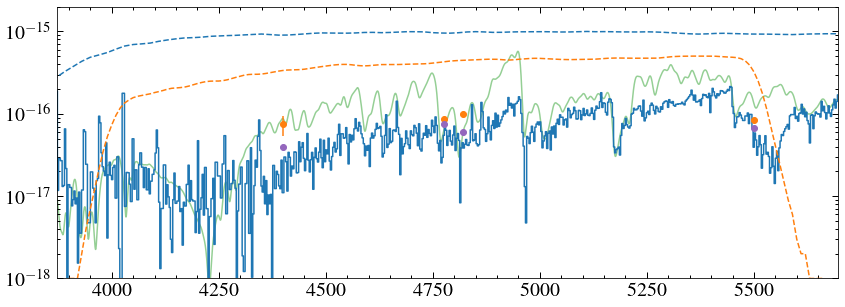

In [49]:


plt.errorbar(gpw, f2m, yerr=e2m, ls='none', marker='o', label='Calculated Flux', c='C1')
plt.step(wo2, fo2, where='mid', c='C0')
plt.plot(pws, pfs, alpha=0.5, zorder=-10, c='C2', label = 'PHOENIX')

plt.errorbar(sdssg_w, sdssg_f.value, yerr=sdssg_fe.value, ls='none', marker='o', c='C1')
plt.errorbar(sdssg_w, specg, ls='none', marker='o', c='C4')

plt.errorbar(B_w, B_f.value, yerr=B_fe.value, ls='none', marker='o', c='C1')
plt.errorbar(B_w, specb, ls='none', marker='o', c='C4')


plt.errorbar(optphot['Wavelength'], opt_fake_phot, ls='none', marker='o', c='C4')


#plt.errorbar([4775.62,5500], [7.267397526787607e-17, 6.221705681914174e-17], ls='none', marker='o', label='Syn Flux', c='C4')

for band in optphot['Band']:
    index = band.find('_')
    inst = band[:index].lower()
    flt = band[index+1:]
    if inst == 'ps':
        inst = 'panstarrs'
        flt = 'PS1.{}'.format(flt)
    if inst == 'gaia':
        flt = flt[0]+flt[1:].lower()
    bpath = '{}{}/{}.dat'.format(filter_path, inst, flt)
    bw, bc = np.loadtxt(bpath, unpack=True)
    plt.plot(bw, bc*1e-15, ls='--')

plt.xlim(wo2[0], wo2[-1])
plt.ylim(1e-18, 2e-15)
plt.yscale('log')

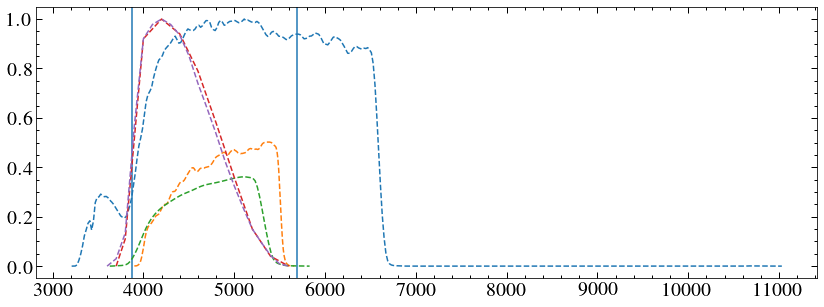

In [41]:
for band in optphot['Band']:
    index = band.find('_')
    inst = band[:index].lower()
    flt = band[index+1:]
    if inst == 'ps':
        inst = 'panstarrs'
        flt = 'PS1.{}'.format(flt)
    if inst == 'gaia':
        flt = flt[0]+flt[1:].lower()
    bpath = '{}{}/{}.dat'.format(filter_path, inst, flt)
    bw, bc = np.loadtxt(bpath, unpack=True)
    plt.plot(bw, bc, ls='--')
[plt.axvline(line) for line in [wo2[0], wo2[-1]]]

bpath = '{}{}/{}.dat'.format(filter_path, 'sdss', 'g')
bw, bc = np.loadtxt(bpath, unpack=True, usecols=(0,1))
plt.plot(bw, bc, ls='--')

Bmag = 18.8 #1953!
Bpath = '{}{}/{}.dat'.format(filter_path, 'johnson', 'johnson_B')
bw, bc = np.loadtxt(Bpath, unpack=True, usecols=(0,1))
plt.plot(bw, bc, ls='--')

Bpath = '{}{}/{}.dat'.format(filter_path, 'bessell', 'bessell_B')
bw, bc = np.loadtxt(Bpath, unpack=True, usecols=(0,1))
plt.plot(bw, bc, ls='--')


Can I use the phoenix model to replace low flux regions?

In [32]:
t1data = Table.read('../../common/quicksaves/2MASS-J23062928-0502285_basic.ecsv')
wt, ft, et = t1data['WAVELENGTH'], t1data['FLUX'], t1data['ERROR']

(1e-30, 6.782113641299545e-12)

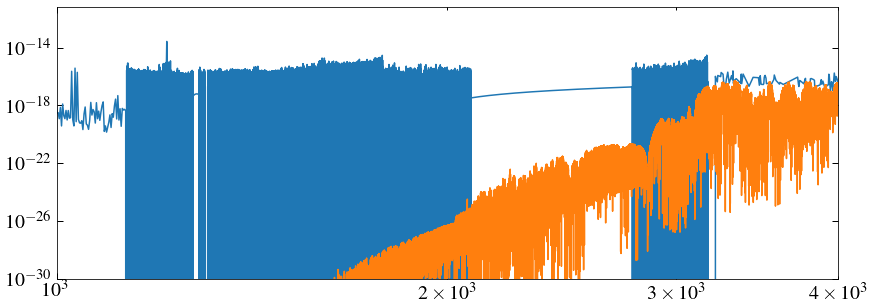

In [33]:
plt.plot(wt,ft)
plt.plot(pw, pf)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1000, 4000)
plt.ylim(1e-30)